# BINARY CLASSIFICATION WITH MACHINE LEARNING MODELS

AIM :- To classify reviews as positive of negative easily helps company to see negative reviewed products easily without reading too much reviews. So, my focus point is negative rated products. So, I divided my target as 0 and 1. 3 and above rated books were collected together as 1 and 1-2 were classified as 0.

My aim in this notebook is to predict reviews as positive or negative from text. To do this, I used machine learning algoritms.

In [ ]:
# Importing Necessary Libraries

# dataframe and series 
import pandas as pd
import numpy as np

# sklearn imports for modeling part
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

# XGBoost and LGBM classifier imports
import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
pd.options.display.max_columns=100

In [2]:
import pandas as pd
df = pd.read_csv('Cleaned_Data.csv', low_memory=False)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewText,summary,unixReviewTime,vote,image,day,month,year,sentiment,review_clean
0,4,True,2014-07-03,A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN,3,7,2014,2,pretty good story a little exaggerated but I l...
1,5,True,2014-05-26,A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN,26,5,2014,2,If youve read other max brand westerns you kno...
2,5,True,2016-09-16,A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN,16,9,2016,2,Love Max always a fun twist
3,5,True,2016-03-03,A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},"As usual for him, a good book",a good,1456963200,NaN,NaN,3,3,2016,2,As usual for him a good book
4,5,True,2015-09-10,AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},MB is one of the original western writers and ...,A Western,1441843200,2.0,NaN,10,9,2015,2,MB is one of the original western writers and ...


I have already cleaned my data but after converting my data to new column, I would like to make sure my new column is clean or not. 

In [3]:
df.isna().sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
style             875
reviewText          0
summary             0
unixReviewTime      0
vote              938
image             999
day                 0
month               0
year                0
sentiment           0
review_clean        0
dtype: int64

## Taking Samples for Modeling 

As my target is highly unbalanced. To teach my model more about minority class, I will take sample data from each balanced classes. 

In [6]:
def calc_two_sentiment(overall):
    '''This function encodes the rating 1 and 2 as 0, others as 1'''
    if overall >= 3:
        return 1
    else:
        return 0
    
# appyling converter to change sentiments from 3 to 2-classed
df['sentiment'] = df['overall'].apply(calc_two_sentiment) 
df['sentiment'].value_counts()

1    882
0    118
Name: sentiment, dtype: int64

In [7]:
df_0 = df.loc[df['sentiment']==0].head(100)
df_1 = df.loc[df['sentiment']==1].head(100)

frames = [df_0, df_1]
df_sampled = pd.concat(frames) #getting together samples

#sample classes - balanced chosen
df_sampled['sentiment'].value_counts() 

0    100
1    100
Name: sentiment, dtype: int64

## Modeling Functions

## LOGISTIC-REGRESSION MODEL

I will use functions for my modeling and spliting parts because I want to get results easily when I changed something in model.

(160,)
(40,)
Accuracy:
TRAIN: 0.99375
TEST: 0.925

Balanced Accuracy:
TRAIN: 0.9936708860759493
TEST: 0.9235588972431077


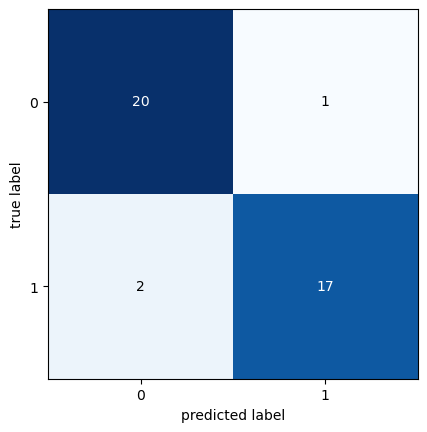

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt

def model_split(df) :
    '''This function splits data to train and test, then vectorized reviews '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], 
                                                        df['sentiment'], test_size=0.2, random_state=42)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['review_clean'])
    
    # train - test vectorized features - tranforming to suitable format for modeling
    train_word_features = word_vectorizer.transform(X_train) 
    test_word_features = word_vectorizer.transform(X_test)
    
    return train_word_features , test_word_features, y_train, y_test 

def model(df,classifier):
    '''this function gives modeling results and confusion matrix also'''
    train_word_features,test_word_features,y_train,y_test = model_split(df)
    classifier.fit(train_word_features, y_train)
    
    # calculating results 
    y_pred_train = classifier.predict(train_word_features)
    y_pred = classifier.predict(test_word_features)
    
    #for smart printing (learned from our lead instructor Bryan Arnold)
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred)}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm)
    plt.show()
    
# choosing classifier and running model
classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
model(df_sampled,classifier)

With simple Logreg, I got my baseline model for 2-balanced class data. I did not work on this much this model, because it is my baseline. I will decide after other models. My main concern is this matrix are wrong predictions on 0. I will try to find the best results according to accuracy and true 0 class predictions.

## DECISION TREE CLASSIFIER

Decision tree classifier is a supervised classification technique which splits data according to certain parameters continuously.

(160,)
(40,)
Accuracy:
TRAIN: 0.7875
TEST: 0.6

Balanced Accuracy:
TRAIN: 0.7888732614471011
TEST: 0.5939849624060151


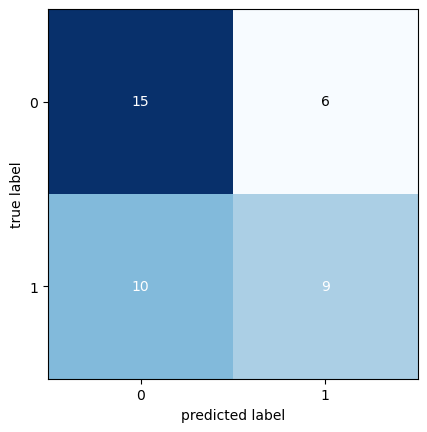

In [14]:
# sklearn imports for modeling part
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

des_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                                        random_state=42, class_weight='balanced')
model(df_sampled,des_tree)

I do not find better results than baseline when I try to tune this model, so I continue to try other models. With simple Logreg, my test accuracy was 0.92, but this one gives 0.59.

## EXTRA-TREE CLASSIFIER

Extra Trees works like a Random Forest. It builds multiple trees and splits nodes using random subsets of features. There are two main differences it does not samples without replacement, and nodes are split on random splits, not best splits. I also used different parameters and tuned them manually.

(160,)
(40,)
Accuracy:
TRAIN: 0.9125
TEST: 0.9

Balanced Accuracy:
TRAIN: 0.9113924050632911
TEST: 0.9022556390977443


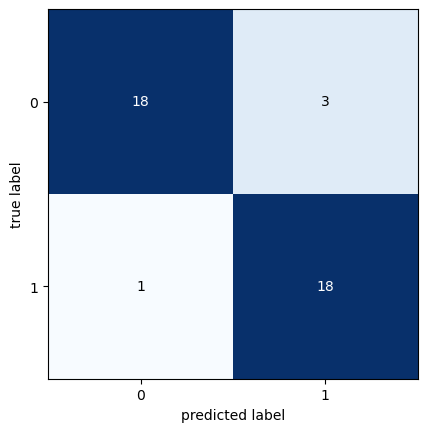

In [15]:
# sklearn imports for modeling part
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf_extra = ExtraTreesClassifier(max_depth=5, criterion= 'entropy', min_samples_leaf=3, min_samples_split=18, 
                          random_state=42, n_estimators = 100, class_weight='balanced', n_jobs = -1)

model(df_sampled,rf_extra)

Got better result than decision tree.

## RANDOM FOREST CLASSIFIER

Random forest models can reduce overfitting risk by randomness as building n_estimators, bootstrapping sample and splitting nodes on the best split among a random subset of the features selected at every node and converting non-homogeneous node into best possibles.



(160,)
(40,)
Accuracy:
TRAIN: 1.0
TEST: 0.9

Balanced Accuracy:
TRAIN: 1.0
TEST: 0.8972431077694235


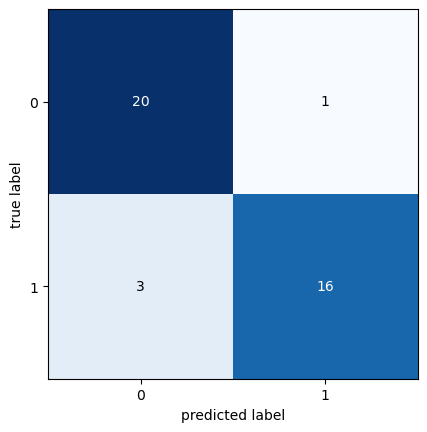

In [16]:
# sklearn imports for modeling part
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                            criterion = 'entropy',max_features = 'sqrt',min_samples_split = 5)
model(df_sampled,rf)

I got the best result with high accuracy among all the models in both test and train, using the parameters. 

In [24]:
import pandas as pd
# combinig all the results into DataFrame
df_results = pd.DataFrame(columns=["Model","train_balanced","test_balanced"])

# for Log-Reg Model
df_results = df_results.append({
                'Model': 'Log-Reg Model',
                'train_balanced' : 0.99,
                'test_balanced' : 0.92}, ignore_index=True)

# for Decision Tree Classifier
df_results = df_results.append({  
                'Model': 'Decision Tree',
                'train_balanced' : 0.78,
                'test_balanced' : 0.60}, ignore_index=True)

# for Extra-Tree Classifier
df_results = df_results.append({   
                'Model': 'Extra-Tree',
                'train_balanced' : 0.91,
                'test_balanced' : 0.90}, ignore_index=True)

# for Random Forest Classifier
df_results = df_results.append({       
                'Model': 'Random Forest',
                'train_balanced' : 1.00,
                'test_balanced' : 0.90}, ignore_index=True)

/var/folders/qt/qwdl18ld00132kwks4v4_79m0000gn/T/ipykernel_6045/4230274576.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/qt/qwdl18ld00132kwks4v4_79m0000gn/T/ipykernel_6045/4230274576.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/qt/qwdl18ld00132kwks4v4_79m0000gn/T/ipykernel_6045/4230274576.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
/var/folders/qt/qwdl18ld00132kwks4v4_79m0000gn/T/ipykernel_6045/4230274576.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({


In [23]:
df_results # show results 

,Model,train_balanced,test_balanced
0,Log-Reg Model,0.99,0.92
1,Decision Tree,0.78,0.60
2,Extra-Tree,0.91,0.90
3,Random Forest,1.00,0.90


According to results, my baseline did better than others. I can work on to tune these models and can get better results.

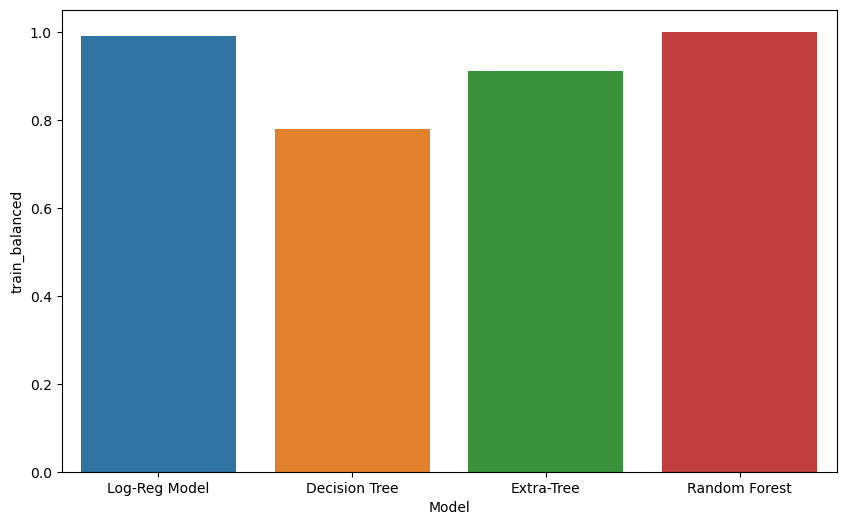

In [27]:
import seaborn as sns 
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Model', y='train_balanced', data=df_results)

From the above bar chart, we can depict that Random Forest gives accurate results, though log-reg model is close to baseline. But Random Forest is accurate.